In [33]:
# import matplotlib
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler
from scipy.optimize import minimize
from scipy.special import jnp_zeros #
import scipy.io
import pickle
color_cycle = cycler('color',['#377eb8','#4daf4a','#e41a1c','#984ea3','#ff7f00','#a65628','#f781bf','#999999','#ffff33'])
mpl.rc('figure',figsize=[10,2.7]) # figure size in inch
mpl.rc('figure',dpi=200) # inline dpi (=display size in browser)
mpl.rc('font',size=8.0)
mpl.rc('lines',linewidth=0.7) 
mpl.rc('axes',prop_cycle=color_cycle,grid=True,linewidth=0.5,axisbelow=True,unicode_minus=False)
mpl.rc('grid',linewidth=0.3,linestyle=':')
mpl.rc('legend',fontsize='small',framealpha=1.0,numpoints=1)
mpl.rc('svg',fonttype='none')
mpl.rc('savefig',dpi=300)

import helper functions from CFS (see source code) to acess the result files.


In [34]:
# import cfs tools
from sys import path
path.append('/home/sand/.cfs/CFS-2022W-Linux/share/python/')
from hdf5_tools import *

In [35]:
rho_w = 998.2 # water density
g = 9.81 # gravity of earth
# geometry
rg = 0.05 # radius glass edge
hw = 0.07 # water height

Transfer function: force
----------------------

A harmonic force is applied on the bottom of the container.
Calculate and plot the transfer function for the horizontal reaction force on the container wall (pressure integral) over the container displacement, and compare to the transfer function obtained with the applied force over container displacement.


In [36]:
simulationName = "Container2DforceTorque_waterWaveMech"
# We read the step values (in Hz) to use in the plot for the transfer function:
f_step = get_step_values(f'results_hdf5/{simulationName}.cfs')[0]

omega_steps = f_step*2*np.pi # omega = 2*pi*f
omega_trans = omega_steps**2*rg/g # dimensionless omega using water radius and gravity of earth


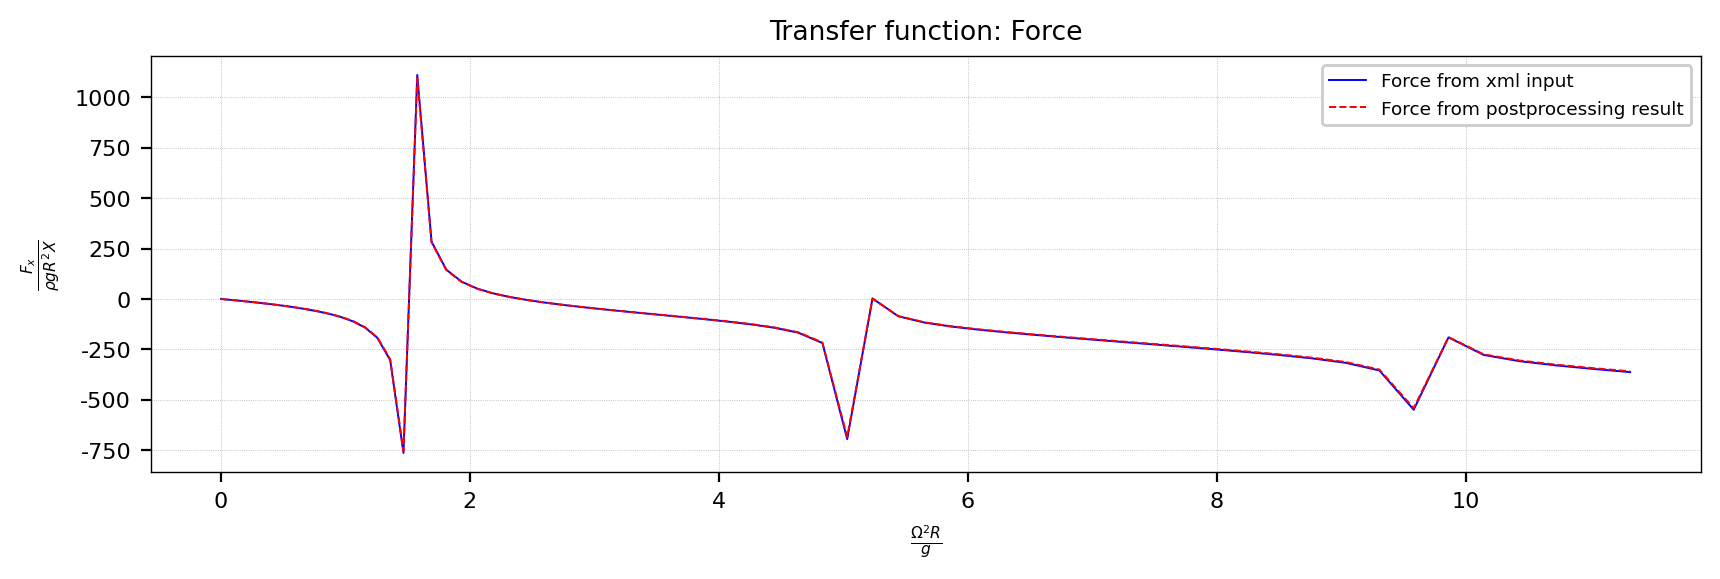

In [37]:
# get deflection data of node P_0
data_P0=np.genfromtxt(f'./history/{simulationName}-mechDisplacement-node-15-P_0.hist', delimiter='  ') 
u_P0_x_ampl = data_P0[:,1]
u_P0_x_phase = data_P0[:,2]*np.pi/180
u_P0_x = u_P0_x_ampl * np.exp(1j*u_P0_x_phase) #transform to complex value

scalefac_Fx = rho_w*g*rg**2 # scale factor 

## Force transfer function
F_x = 10 # applied force in xml input
HF_x = F_x / u_P0_x # transfer function
HF_x = np.real(np.sign(HF_x))*abs(HF_x) # (sign * abs) to get signed real valued function
HF_x_scaled = HF_x / scalefac_Fx # scale

## Force transfer function using postprocessing result
data_force = np.genfromtxt(f'./history/{simulationName}-waterSurfaceForce-surfRegion-L_coupling.hist', delimiter='  ')

fx_ampl = data_force[:,1]
fx_phase = data_force[:,2]*np.pi/180
fx = fx_ampl * np.exp(1j*fx_phase)
HF_x_measured = fx / u_P0_x # transfer function
HF_x_measured = np.real(np.sign(HF_x_measured))*abs(HF_x_measured) # (sign * abs) to get signed real valued function
HF_x_measured_scaled = -HF_x_measured / scalefac_Fx # scale (negative sign - applied force + reaction force = 0)

plt.figure(1)
plt.plot(omega_trans, HF_x_scaled, label='Force from xml input', color='b') 
plt.plot(omega_trans, HF_x_measured_scaled, label='Force from postprocessing result', linestyle='dashed', color='r') 
plt.xlabel(r'$\frac{\Omega^2R}{g}$')
plt.ylabel(r'$\frac{F_x}{\rho gR^2X}$')
plt.title('Transfer function: Force')
plt.legend()
plt.show()


Transfer function: torque
----------------------

Calculate the transfer function for the reaction torque (y-direction) resulting from water pressure on container wall (integral r x f) over the container displacement. Compare to the reaction torque obtained from a spring attached on the right edge of the container (M = F * radius, F = stiffness * displacement)

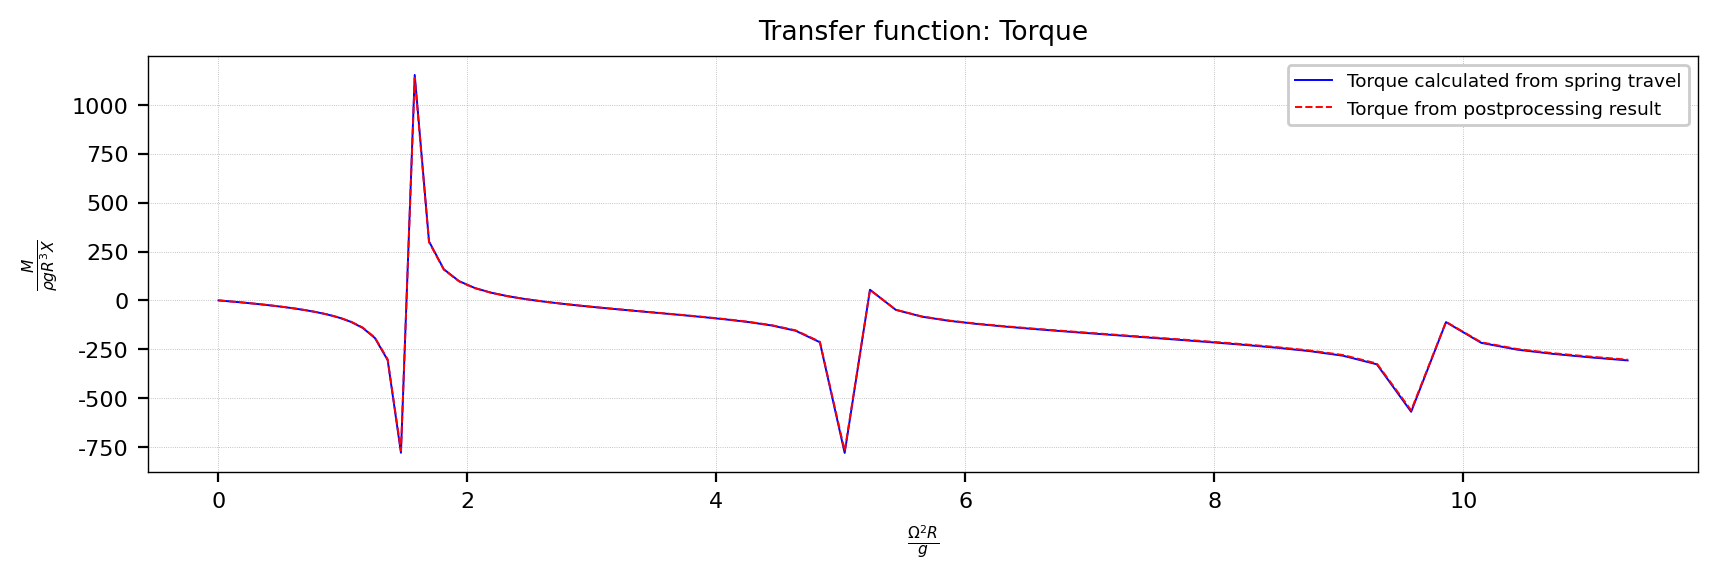

In [38]:
# get deflection data of node P_1
data_P1=np.genfromtxt(f'./history/{simulationName}-mechDisplacement-node-48-P_1.hist', delimiter='  ')
u_P1_y_ampl = data_P1[:,3]
u_P1_y_phase = data_P1[:,4]*np.pi/180
u_P1_y = u_P1_y_ampl * np.exp(1j*u_P1_y_phase) #transform to complex value

scalefac_Mx = (rho_w *g * rg**3) # scale factor 

## Torque transfer function
k_z = 100000 # spring stiffness as defined in xml input
M_y = k_z*u_P1_y*rg # torque 
HM_x = M_y / u_P0_x # transfer function
HM_x = np.real(np.sign(HM_x))*abs(HM_x) # (sign * abs) to get signed real valued function
HM_x_scaled = HM_x / scalefac_Mx # scale

## Force transfer function using postprocessing result
data_torque = np.genfromtxt(f'./history/{simulationName}-waterSurfaceTorque-surfRegion-L_coupling.hist', delimiter='  ')

My_ampl = data_torque[:,1]
My_phase = data_torque[:,2]*np.pi/180
My = My_ampl * np.exp(1j*My_phase)
My = My - 0.07 * fx # Torque around center of origin
HM_x_measured = My / u_P0_x # transfer function
HM_x_measured = np.real(np.sign(HM_x_measured))*abs(HM_x_measured) # (sign * abs) to get signed real valued function
HM_x_measured_scaled = HM_x_measured / scalefac_Mx # scale 

## Plot
plt.figure(2)
plt.plot(omega_trans, HM_x_scaled, label='Torque calculated from spring travel', color='b') 
plt.plot(omega_trans, HM_x_measured_scaled, label='Torque from postprocessing result', linestyle='dashed', color='r') 
plt.xlabel(r'$\frac{\Omega^2R}{g}$')
plt.ylabel(r'$\frac{M}{\rho gR^3X}$')
plt.title('Transfer function: Torque')
plt.legend()
plt.show()
